In [303]:
%matplotlib inline
import numpy as np
from tqdm import tqdm
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

NEIGHBORS_FOOTPRINT = np.array([[1,1,1], [1,0,1], [1,1,1]])


def parse(text):
    return np.array([list(line) for line in text.splitlines()])

def to_string(arr):
    return "\n".join(["".join(row) for row in arr])

def get_neighbor_counts(arr, char):
    binary = (arr == char).astype(np.int)
    return ndimage.generic_filter(binary, np.sum, footprint=NEIGHBORS_FOOTPRINT, mode="constant")

def turn(arr):
    arr_next = arr.copy()
    trees = (arr == "|")
    opens = (arr == ".")
    lumbers = (arr == "#")
    
    # An open acre will become filled with trees if three or more adjacent acres contained trees.
    n_trees = get_neighbor_counts(arr, "|")
    arr_next[opens & (n_trees >= 3)] = "|"
    
    # An acre filled with trees will become a lumberyard if three or more adjacent acres were lumberyards.
    n_lumbers = get_neighbor_counts(arr, "#")
    arr_next[trees & (n_lumbers >= 3)] = "#"
    
    # An acre containing a lumberyard will remain a lumberyard if it was adjacent to at least one other
    # lumberyard and at least one acre containing trees. Otherwise, it becomes open.
    remain_lumber = (n_lumbers >= 1) & (n_trees >= 1)
    arr_next[lumbers & remain_lumber] = "#"
    arr_next[lumbers & ~remain_lumber] = "."
    
    return arr_next

def score(arr):
    return (arr == "#").sum() * (arr == "|").sum()

def play(arr, rounds, verbose=False):
    if verbose:
        print("Initial state:")
        print(to_string(arr))
        print()
    counter = range(1, rounds + 1) if verbose else tqdm(range(1, rounds + 1))
    for i in counter:
        arr = turn(arr)
        if verbose:
            print(f"After {i} minute{'s' if i > 1 else ''}")
            print(to_string(arr))
    return arr

In [59]:
test_input = """.#.#...|#.
.....#|##|
.|..|...#.
..|#.....#
#.#|||#|#|
...#.||...
.|....|...
||...#|.#|
|.||||..|.
...#.|..|."""
arr = parse(test_input)
res = play(arr, 10, verbose=True)
print("score:", score(res))
assert score(res) == 1147

Initial state:
.#.#...|#.
.....#|##|
.|..|...#.
..|#.....#
#.#|||#|#|
...#.||...
.|....|...
||...#|.#|
|.||||..|.
...#.|..|.

After 1 minute
.......##.
......|###
.|..|...#.
..|#||...#
..##||.|#|
...#||||..
||...|||..
|||||.||.|
||||||||||
....||..|.
After 2 minutes
.......#..
......|#..
.|.|||....
..##|||..#
..###|||#|
...#|||||.
|||||||||.
||||||||||
||||||||||
.|||||||||
After 3 minutes
.......#..
....|||#..
.|.||||...
..###|||.#
...##|||#|
.||##|||||
||||||||||
||||||||||
||||||||||
||||||||||
After 4 minutes
.....|.#..
...||||#..
.|.#||||..
..###||||#
...###||#|
|||##|||||
||||||||||
||||||||||
||||||||||
||||||||||
After 5 minutes
....|||#..
...||||#..
.|.##||||.
..####|||#
.|.###||#|
|||###||||
||||||||||
||||||||||
||||||||||
||||||||||
After 6 minutes
...||||#..
...||||#..
.|.###|||.
..#.##|||#
|||#.##|#|
|||###||||
||||#|||||
||||||||||
||||||||||
||||||||||
After 7 minutes
...||||#..
..||#|##..
.|.####||.
||#..##||#
||##.##|#|
|||####|||
|||###||||
||||||||||
||||||||||
||||

### Part 1

In [312]:
with open("../inputs/18/input.txt", "r") as fp:
    text = fp.read()
    arr = parse(text)
score(play(arr, 10))


100%|██████████| 10/10 [00:00<00:00, 36.66it/s]

505895

### Part 2

Computationally outrageous so there must be a recurring pattern.

In [256]:
with open("../inputs/18/input.txt", "r") as fp:
    text = fp.read()
    arr = parse(text)
arrs = [arr.copy()]
for i in range(1000):
    arr = turn(arr)
    arrs.append(arr.copy())
arrs = np.array(arrs)

In [280]:
pairs = []
for i in range(len(arrs)):
    if (arrs[i] == arrs[500]).all():
        pairs.append(i)
pairs = np.array(pairs)
pairs

array([416, 500, 584, 668, 752, 836, 920])

In [281]:
np.diff(pairs)

array([84, 84, 84, 84, 84, 84])

In [283]:
for i in range(500, len(arrs) - 84):
    assert (arrs[i] == arrs[i+84]).all()

In [324]:
assert (1000000000 - 496) % 84 == 0

In [299]:
score(arrs[496])

139590

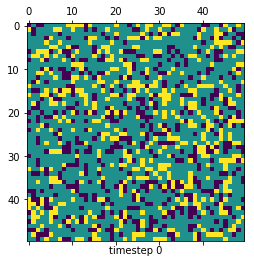

In [323]:
fig, ax = plt.subplots()

p = ax.matshow(np.where(arrs[0] == ".", 0, np.where(arrs[0] == "#", -1, 1)))

def update(i):
    label = 'timestep {0}'.format(i)
    p.set_data(np.where(arrs[i] == ".", 0, np.where(arrs[i] == "#", -1, 1)))
    ax.set_xlabel(label)
    return p, ax

anim = FuncAnimation(fig, update, frames=np.arange(0, 600), interval=50)
anim.save('/tmp/line.gif', dpi=80, writer='imagemagick')

In [326]:
from IPython.display import Image
Image(filename='../assets/day18.gif')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
